# Dataset

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

## Dataset direction

In [2]:
TRAIN_DATA_DIR = 'training_dataset'
VALID_DATA_DIR = 'valid_dataset'
TEST_DATA_DIR = 'test_dataset'

## Reshape dataset image & mask size to 256 x 256

In [3]:
import os, sys
from PIL import Image
from tqdm import tqdm

size = (256, 256)

image_path = 'training_dataset/image/'
image_outpath = 'training_dataset/image_reshape/'
image_names = sorted(next(os.walk(image_path))[-1])

for id in tqdm(range(len(image_names)), desc="Images"):
	path = image_path + image_names[id]
	outpath = image_outpath + image_names[id]
	try:
		im = Image.open(path)
		im = im.resize(size)
		im.save(outpath)
		
	except IOError:
		print("Error occured")
  
image_path = 'training_dataset/mask/'
image_outpath = 'training_dataset/mask_reshape/'
image_names = sorted(next(os.walk(image_path))[-1])

for id in tqdm(range(len(image_names)), desc="Images"):
	path = image_path + image_names[id]
	outpath = image_outpath + image_names[id]
	try:
		im = Image.open(path)
		im = im.resize(size)
		im.save(outpath)
		
	except IOError:
		print("Error occured")
  
image_path = 'valid_dataset/image/'
image_outpath = 'valid_dataset/image_reshape/'
image_names = sorted(next(os.walk(image_path))[-1])

for id in tqdm(range(len(image_names)), desc="Images"):
	path = image_path + image_names[id]
	outpath = image_outpath + image_names[id]
	try:
		im = Image.open(path)
		im = im.resize(size)
		im.save(outpath)
		
	except IOError:
		print("Error occured")

image_path = 'valid_dataset/mask/'
image_outpath = 'valid_dataset/mask_reshape/'
image_names = sorted(next(os.walk(image_path))[-1])

for id in tqdm(range(len(image_names)), desc="Images"):
	path = image_path + image_names[id]
	outpath = image_outpath + image_names[id]
	try:
		im = Image.open(path)
		im = im.resize(size)
		im.save(outpath)
		
	except IOError:
		print("Error occured")


image_path = 'test_dataset/image/'
image_outpath = 'test_dataset/image_reshape/'
image_names = sorted(next(os.walk(image_path))[-1])

for id in tqdm(range(len(image_names)), desc="Images"):
	path = image_path + image_names[id]
	outpath = image_outpath + image_names[id]
	try:
		im = Image.open(path)
		im = im.resize(size)
		im.save(outpath)
		
	except IOError:
		print("Error occured")


image_path = 'test_dataset/mask/'
image_outpath = 'test_dataset/mask_reshape/'
image_names = sorted(next(os.walk(image_path))[-1])

for id in tqdm(range(len(image_names)), desc="Images"):
	path = image_path + image_names[id]
	outpath = image_outpath + image_names[id]
	try:
		im = Image.open(path)
		im = im.resize(size)
		im.save(outpath)
		
	except IOError:
		print("Error occured")




Images: 100%|██████████| 12/12 [00:00<00:00, 193.51it/s]


## Train, valid & test dataset direction 

In [4]:
x_train_dir = os.path.join(TRAIN_DATA_DIR, 'image_reshape')
y_train_dir = os.path.join(TRAIN_DATA_DIR, 'mask_reshape')

x_valid_dir = os.path.join(VALID_DATA_DIR, 'image_reshape')
y_valid_dir = os.path.join(VALID_DATA_DIR, 'mask_reshape')

x_test_dir = os.path.join(TEST_DATA_DIR, 'image_reshape')
y_test_dir = os.path.join(TEST_DATA_DIR, 'mask_reshape')

# Helper function for data visualization

In [5]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap='gray')
    plt.show()
    

# Dataloader

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [7]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset

class WaterDataSet(Dataset):
    
    CLASSES = ['water', 'not-water']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask != v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

## Look at some data we have

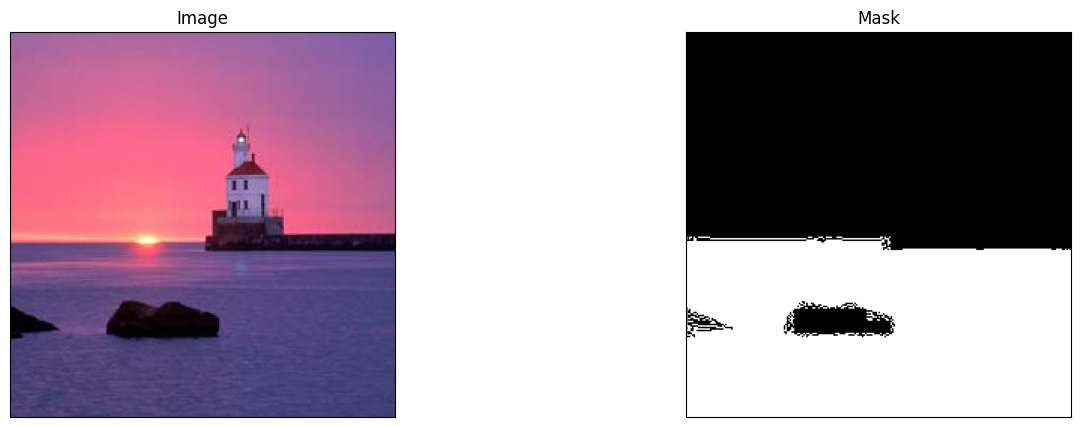

In [8]:
dataset = WaterDataSet(x_train_dir, y_train_dir, classes=['water'])

id = np.random.randint(len(dataset))
image, mask = dataset[id] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)

In [9]:
import albumentations as albu

In [10]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

# Create model and train

In [11]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils

c:\Users\CZR\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load pretrained model & decide encoder, encoder_weight, activation function

In [12]:
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['water']
ACTIVATION = 'sigmoid' 
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
current_model = torch.load("pretrain_model/model_FPN_mobilenet_v2_DiceLoss_best_model40.pth")
current_model_name = "./best_model/model_FPN_mobilenet_v2_DiceLoss_best_model40.pth"

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# Training

## Load train & valid dataset

In [13]:
train_dataset = WaterDataSet(
    x_train_dir, 
    y_train_dir, 
    augmentation=None, 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = WaterDataSet(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=None, 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

## Decide loss function, threshold & optimizer 

In [14]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=current_model.parameters(), lr=0.0001),
])

## Create epoch runners 

In [15]:
train_epoch = smp.utils.train.TrainEpoch(
    current_model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    current_model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

## Train model for 40 epochs & save best model

In [330]:
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(current_model, current_model_name)
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 20/20 [00:00<00:00, 60.96it/s, dice_loss - 0.3949, iou_score - 0.5325]
Model saved!

Epoch: 1
valid: 100%|██████████| 20/20 [00:00<00:00, 61.87it/s, dice_loss - 0.4057, iou_score - 0.52]  

Epoch: 2
valid: 100%|██████████| 20/20 [00:00<00:00, 61.90it/s, dice_loss - 0.3885, iou_score - 0.5355]
Model saved!

Epoch: 3
valid: 100%|██████████| 20/20 [00:00<00:00, 62.10it/s, dice_loss - 0.3893, iou_score - 0.5334]

Epoch: 4
valid: 100%|██████████| 20/20 [00:00<00:00, 60.23it/s, dice_loss - 0.405, iou_score - 0.518]  

Epoch: 5
valid: 100%|██████████| 20/20 [00:00<00:00, 56.32it/s, dice_loss - 0.4273, iou_score - 0.4988]

Epoch: 6
valid: 100%|██████████| 20/20 [00:00<00:00, 61.52it/s, dice_loss - 0.44, iou_score - 0.487]   

Epoch: 7
valid: 100%|██████████| 20/20 [00:00<00:00, 60.59it/s, dice_loss - 0.4628, iou_score - 0.4651]

Epoch: 8
valid: 100%|██████████| 20/20 [00:00<00:00, 57.96it/s, dice_loss - 0.4639, iou_score - 0.4662]

Epoch: 9
valid: 100%|███████

# Test

## Load best saved model

In [16]:
best_model = torch.load(current_model_name)

## Decide loss function & load test dataset

In [17]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

preprocessing_fn = smp.encoders.get_preprocessing_fn('mobilenet_v2', 'imagenet')
# create test dataset
test_dataset = WaterDataSet(
    x_test_dir, 
    y_test_dir,
    augmentation=None,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

# test dataset without transformations for image visualization
test_dataset_vis = WaterDataSet(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

## Create epoch runners 

In [18]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)
print(best_model)
logs = test_epoch.run(test_dataloader)

FPN(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1,

## Visualize predictions

Images:   0%|          | 0/12 [00:00<?, ?it/s]

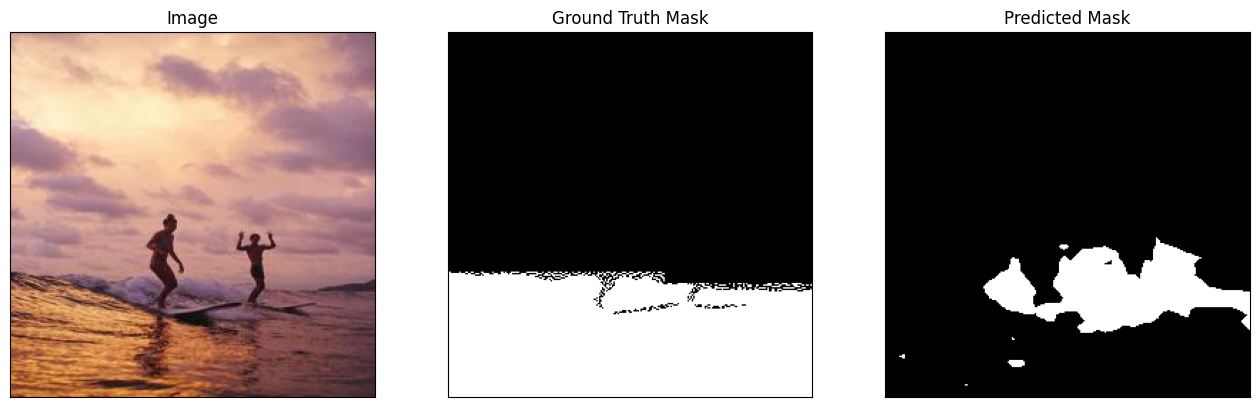

Images:   8%|▊         | 1/12 [00:00<00:01,  5.78it/s]

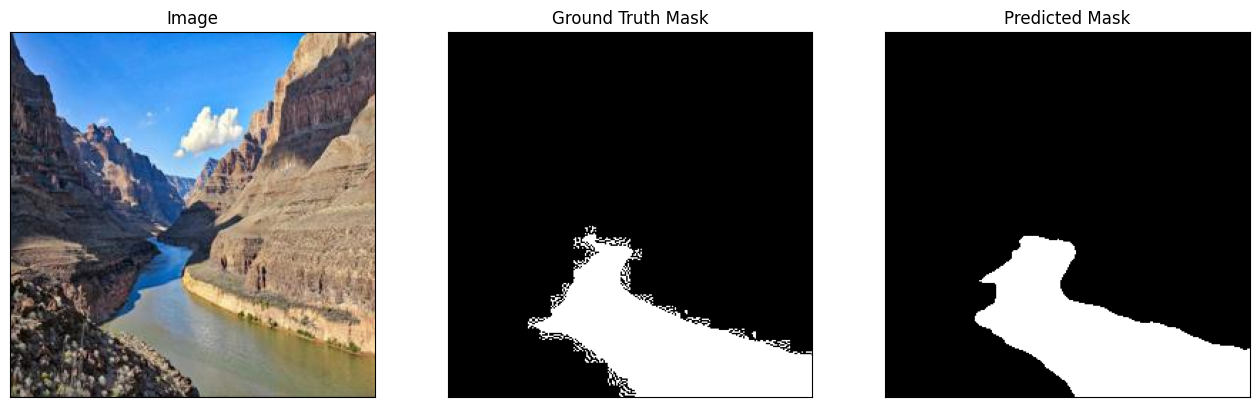

Images:  17%|█▋        | 2/12 [00:00<00:01,  6.25it/s]

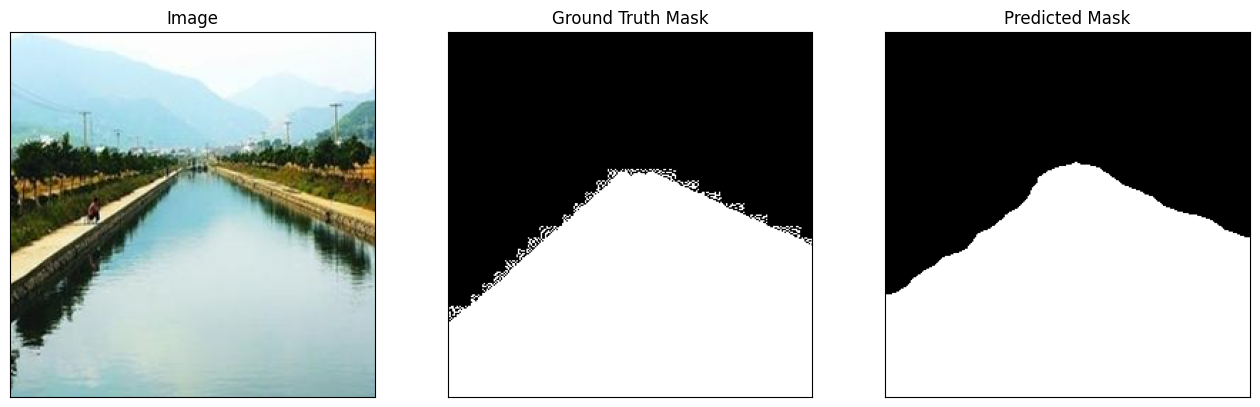

Images:  25%|██▌       | 3/12 [00:00<00:01,  6.69it/s]

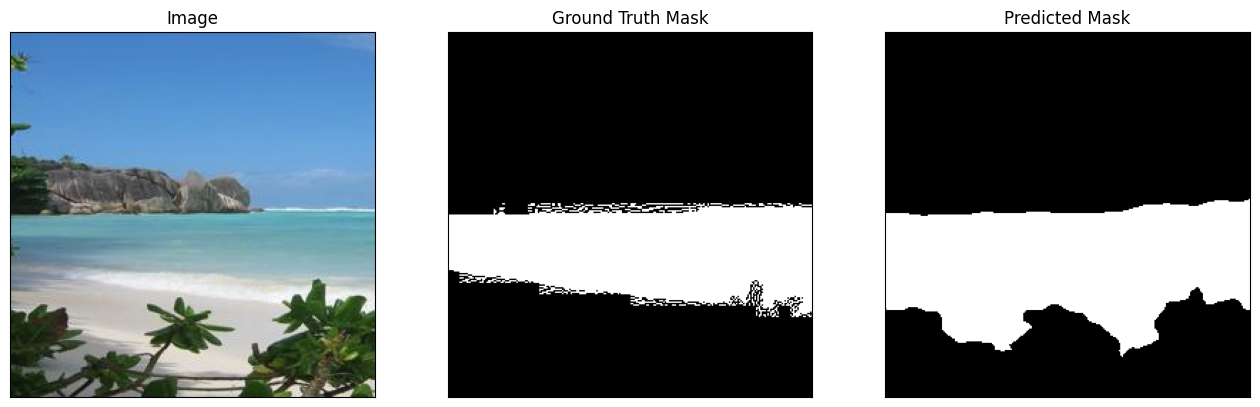

Images:  33%|███▎      | 4/12 [00:00<00:01,  6.95it/s]

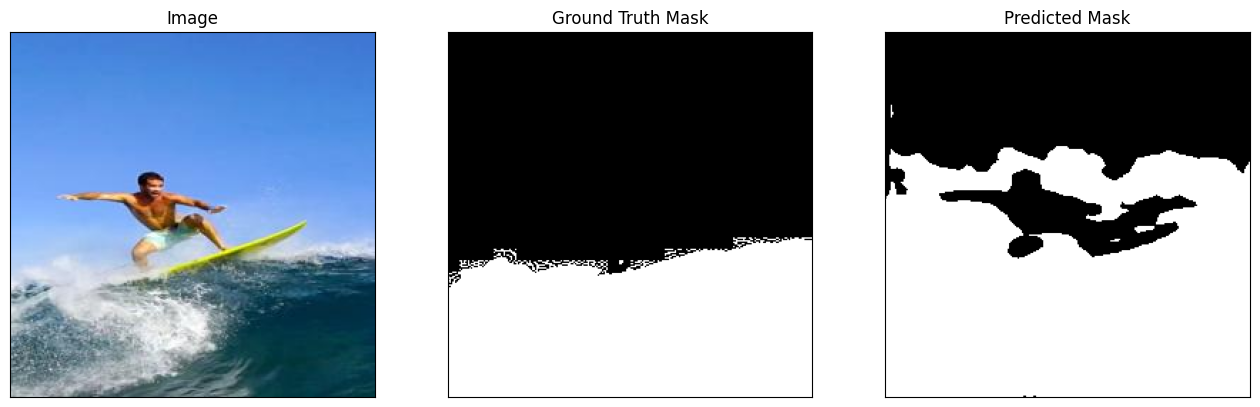

Images:  42%|████▏     | 5/12 [00:00<00:00,  7.04it/s]

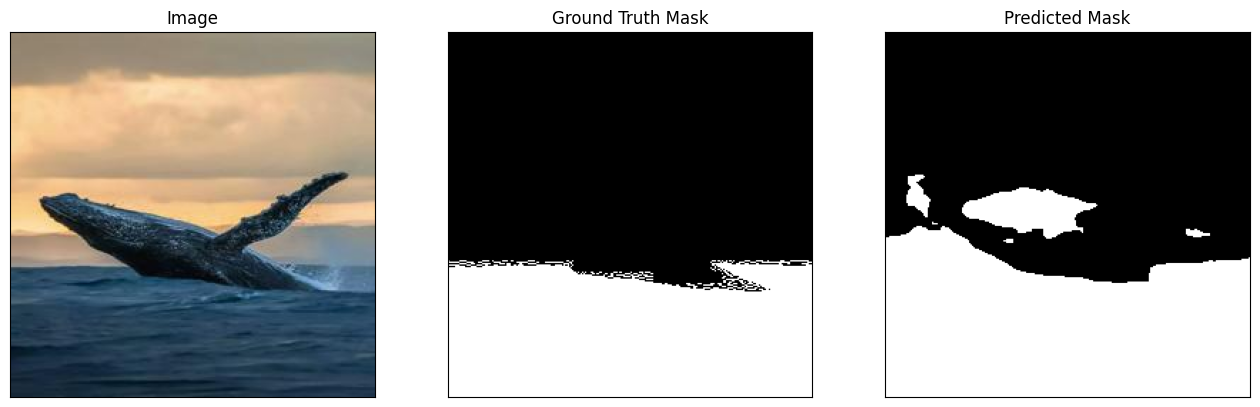

Images:  50%|█████     | 6/12 [00:00<00:00,  6.96it/s]

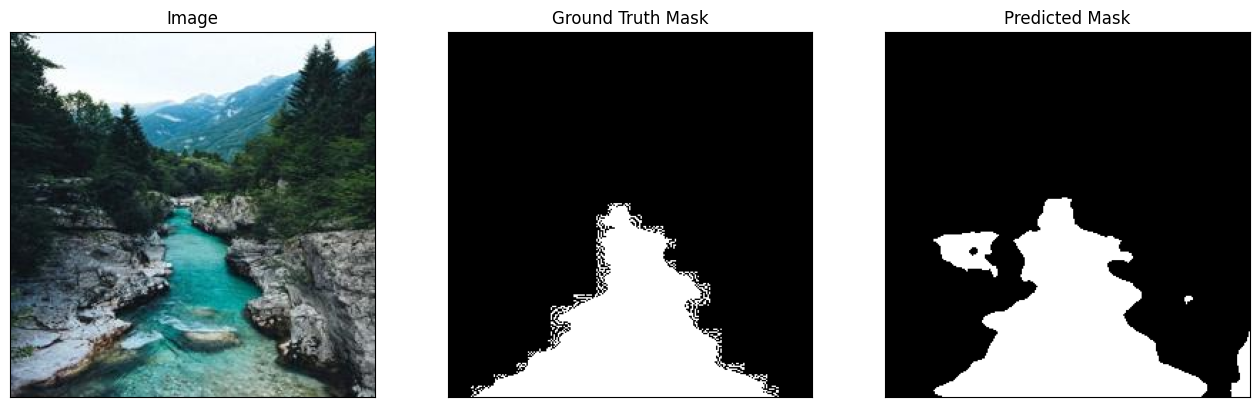

Images:  58%|█████▊    | 7/12 [00:01<00:00,  6.97it/s]

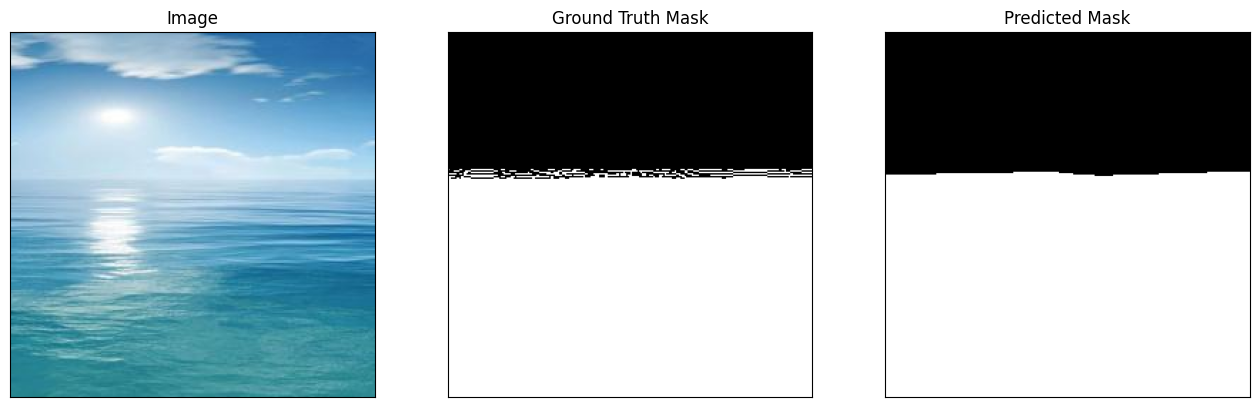

Images:  67%|██████▋   | 8/12 [00:01<00:00,  6.60it/s]

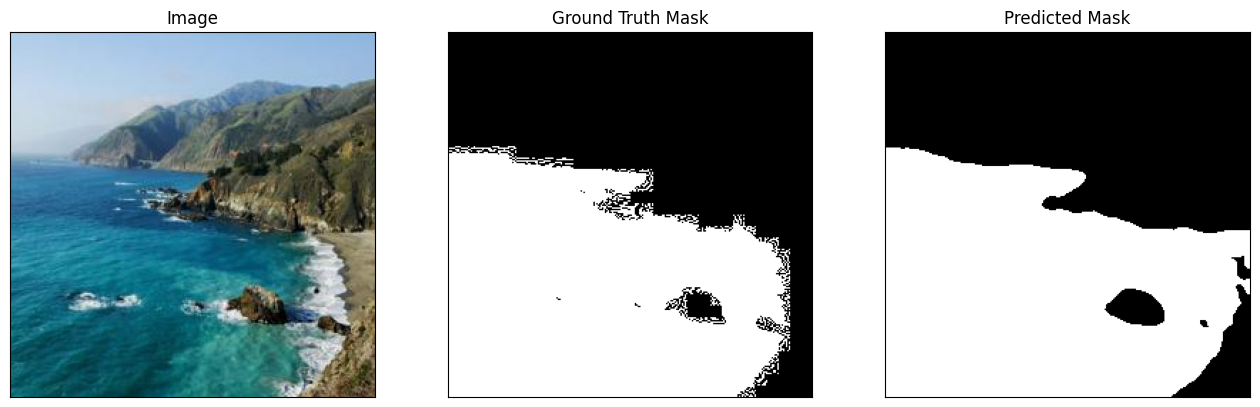

Images:  75%|███████▌  | 9/12 [00:01<00:00,  6.70it/s]

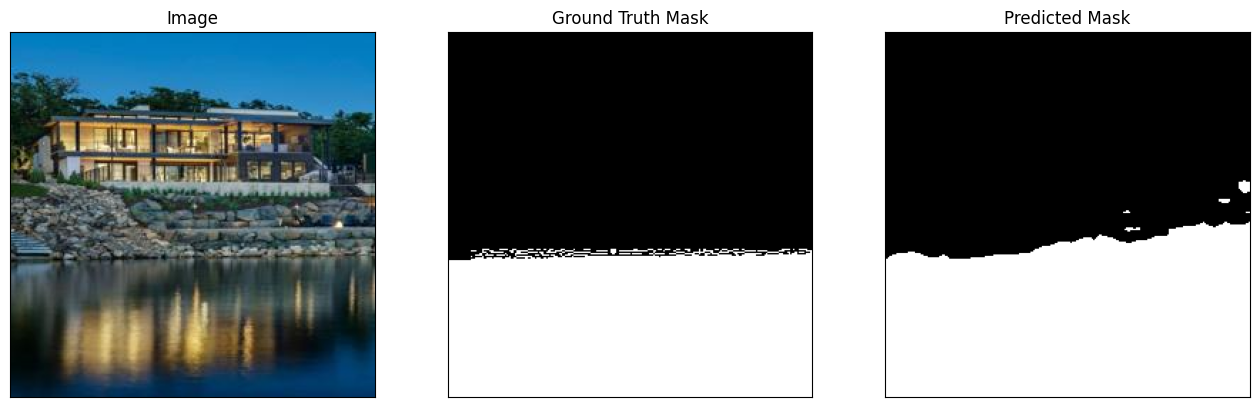

Images:  83%|████████▎ | 10/12 [00:01<00:00,  6.80it/s]

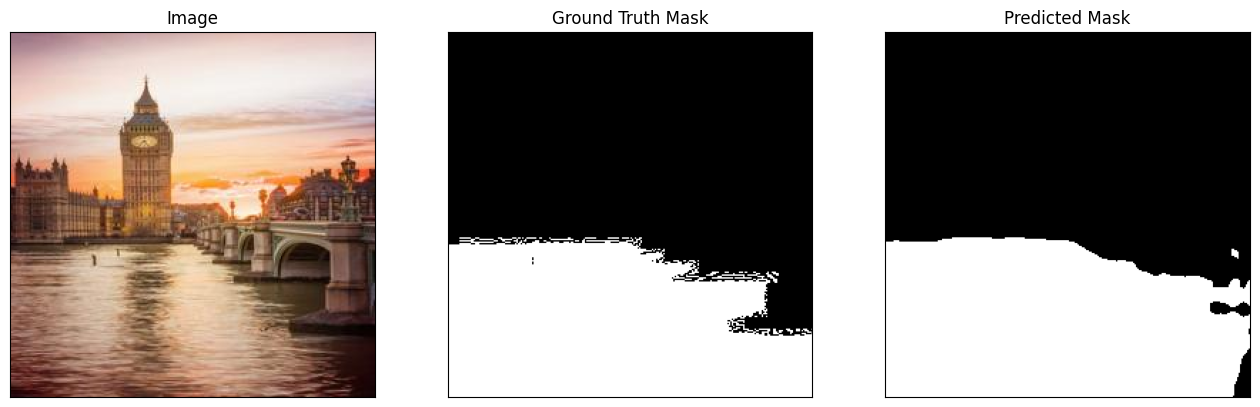

Images:  92%|█████████▏| 11/12 [00:01<00:00,  6.75it/s]

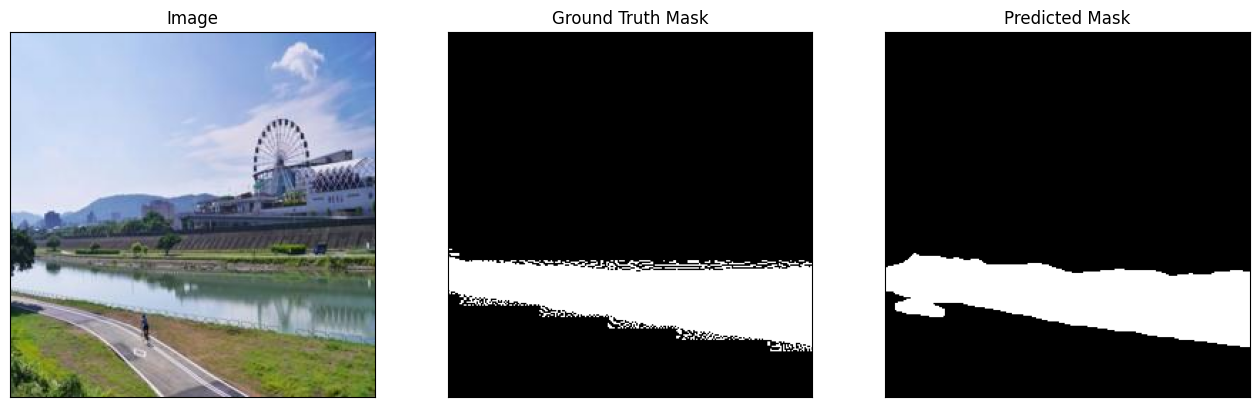

Images: 100%|██████████| 12/12 [00:01<00:00,  6.83it/s]


In [19]:
image_path = 'test_dataset/image/'
image_outpath = 'predict_mask/'
image_names = sorted(next(os.walk(image_path))[-1])

for id in tqdm(range(len(image_names)), desc="Images"):
    path = image_path + image_names[id]
    outpath = image_outpath + test_dataset.ids[id].replace('input', 'output')
    try:
        image_vis = test_dataset_vis[id][0].astype('uint8')
        image, gt_mask = test_dataset[id]
        
        gt_mask = gt_mask.squeeze()
        
        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
        pr_mask = best_model.predict(x_tensor)
        pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
        visualize(
            image=image_vis, 
            ground_truth_mask=gt_mask, 
            predicted_mask=pr_mask
        )
        
        img = cv2.imread(path)
        height = img.shape[0]
        width = img.shape[1]
        pr_mask = (pr_mask * 255).astype(np.uint8)
        pr_mask = cv2.resize(pr_mask,(width, height))
        cv2.imwrite(outpath, pr_mask)
        
    except IOError:
        print("Error occured")

## Calculate IOU

In [20]:
import cv2
import numpy as np

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

mask_filenames_1 = ["test_dataset/mask/input1.jpg","test_dataset/mask/input2.jpg","test_dataset/mask/input3.jpg","test_dataset/mask/input4.jpg","test_dataset/mask/input5.jpg","test_dataset/mask/input6.jpg","test_dataset/mask/input7.jpg","test_dataset/mask/input8.jpg","test_dataset/mask/input9.jpg","test_dataset/mask/input10.jpg","test_dataset/mask/input11.jpg","test_dataset/mask/input12.jpg"]

mask_filenames_2 = ["predict_mask/output1.jpg","predict_mask/output2.jpg","predict_mask/output3.jpg","predict_mask/output4.jpg","predict_mask/output5.jpg","predict_mask/output6.jpg","predict_mask/output7.jpg","predict_mask/output8.jpg","predict_mask/output9.jpg","predict_mask/output10.jpg","predict_mask/output11.jpg","predict_mask/output12.jpg"]

total_iou = 0

for i in range(12): 
    mask1 = cv2.imread(mask_filenames_1[i], cv2.IMREAD_GRAYSCALE)
    mask2 = cv2.imread(mask_filenames_2[i], cv2.IMREAD_GRAYSCALE)

    _, mask1 = cv2.threshold(mask1, 128, 255, cv2.THRESH_BINARY)
    _, mask2 = cv2.threshold(mask2, 128, 255, cv2.THRESH_BINARY)

    iou = calculate_iou(mask1, mask2)
    total_iou += iou
    print(f"IoU for pair {i + 1}: {iou}")

average_iou = total_iou / len(mask_filenames_1)
print(f"Average IoU: {average_iou}")


IoU for pair 1: 0.14961687267054596
IoU for pair 2: 0.6418781630491739
IoU for pair 3: 0.8121762580910739
IoU for pair 4: 0.7603595292709684
IoU for pair 5: 0.9744266432382742
IoU for pair 6: 0.9187691086339128
IoU for pair 7: 0.9019346812193481
IoU for pair 8: 0.8889452095055949
IoU for pair 9: 0.8225064749722502
IoU for pair 10: 0.8527943006152745
IoU for pair 11: 0.9476763907734057
IoU for pair 12: 0.6984425684105464
Average IoU: 0.7807938500375308
